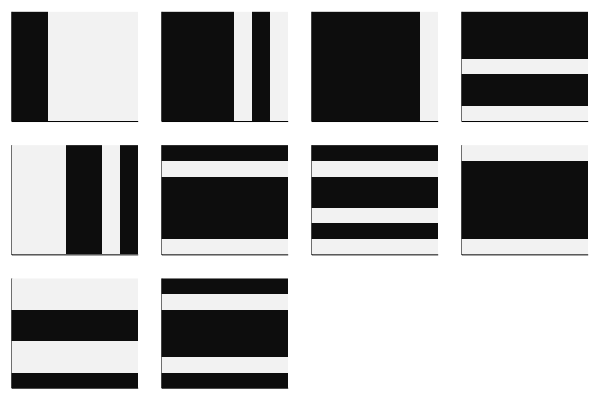

In [1]:
using Random
using Plots

n = 7
train = 10

#if repeats = false, need to find a way to not have duplicates
#check if train < 2^(n+1) - 2

function bars_and_stripes(train = 10, repeats = true) #Samples train data samples from the nxn bars_and_stripes synthetic dataset
    data = []
    for i in 1:train
        S = Int64[]
        while length(S) == 0 #Ensures length(S) is not 0 so we get truly uniform distribution over the whole bars and stripes dataset
            randsubseq!(S, collect(1:n), 0.5)
        end
        if 1 in S
            b = repeat(Bool[1], n)
        else
            b = repeat(Bool[0], n)
        end
        for i in 2:n
            temp = repeat(Bool[0], n)
            if i in S
                temp = repeat(Bool[1], n)
            end
            b = hcat(b, temp)
        end
        flip = rand() < 0.5
        if length(S) == n
            ret = flip ? b : .!b
        else
            ret = flip ? b : rotl90(b)
        end
        push!(data, ret)
    end
    return data
end

data_train = bars_and_stripes(train) #Stores data in data_train

plot([heatmap(x, color=:grays, colorbar = false, ticks = false) for x in data_train]...)

In [2]:
using Yao
using Flux

N = n^2 #Number of qubits

f = Chain(Dense(N, 10, relu), Dense(10, 1, sigmoid))

nparams = sum(length, Flux.params(f))
println("Number of parameters in critic: $nparams")

layers = 5
g = chain(N)
for _ in 1:layers
    for i in 1:N-1
        push!(g, rot(kron(N, i => X, i+1 => X), 0.)) #Implemented using qiskit's definition (https://qiskit.org/documentation/stubs/qiskit.circuit.library.RXXGate.html)
    end
    for i in 1:N-1
        push!(g, rot(kron(N, i => X, i+1 => Y), 0.))
    end
    # for i in 1:N-1
    #     push!(g, rot(kron(N, i => Y, i+1 => Y), 0.))
    # end
    # Not needed YY = XX and IZ and ZI
    for i in 1:N
        push!(g, put(N, i => Rz(0.)))
    end
end
#To enhance expressibility:
# Change circuit ansatz to include more generators
# Change pprior() to become nonconstant
# Gradient doesn't change if you sample from a nonconstant distribution of states? As opposed to all zero state
# Can prove this analytically
# Run on GPU?

nparams = nparameters(g)
println("Number of parameters in generator: $nparams")  
#dispatch!(g, :random)
dispatch!(g, rand(nparams).*2π);

Number of parameters in critic: 181
Number of parameters in generator: 230


Bool[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

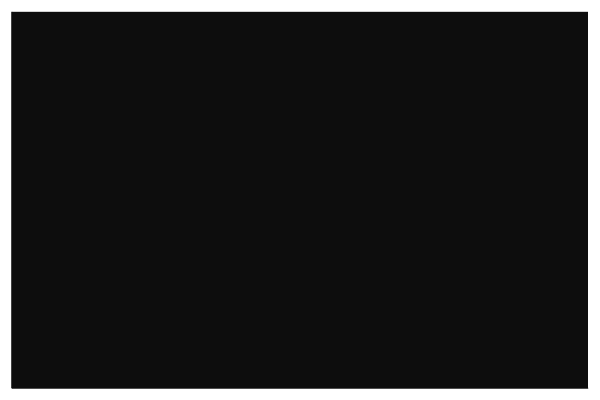

In [3]:
using FLOYao
using Random
using Distributions

# mu = mean(trainstats)
# sigma = std(trainstats)
# println("μ: $mu")
# println("σ: $sigma")
# #dist = Normal(mu, sigma/20)
# dist = Normal(mu, 1)

#ratio = rand(dist) / N
ratio = 0 #if ratio = 0 then pprior() is all 0s
function pprior() #For each square, probability ratio that it's white, where ratio ~ N(mean(data), std(data)) /  N; maybe we can vary pprior later?
    a = rand(N) .< ratio
    return FLOYao.product_state(Int.(a)) #Returns MajoranaReg; Prepares it to be sent through the generator 
end

pprior_example = rand(N) .< ratio
print(pprior_example)
heatmap(rotl90(reshape(pprior_example, n, n)) .> 0.5, color=:grays, colorbar = false, ticks = false)

In [4]:
using Flux: train!
using Yao
using FLOYao
using Statistics

function postprocess(g_output::Vector) #turns the output of reg |> g |> measure into an Int vector
    result = []
    for i in 1:N 
        push!(result, g_output[1][end - i + 1])
    end
    Int.(result)
end

samplemean_batch = 100 #This doesn't need to be that big
dispatch!(g, rand(nparams).*2π)
function run_g(; theta = parameters(g), nbatch = samplemean_batch)
    dispatch!(g, theta)
    samples = []
    for i in 1:nbatch
        z = pprior() #MajoranaReg object
        result = z |> g |> measure |> postprocess
        if i == 1
            samples = result
        else
            samples = hcat(samples, result) #is this operation slow; on another note there has to be a better way to write this function right
        end
    end
    samples
end
#outputs an N * #samples matrix

function run_d_fake(samples)
    if size(samples)[1] != N #Require samples to be an N x #samples matrix
        println("Improper formatting of samples")
        return
    end
    samples |> d
end

function run_d_real() #Runs d on all training data
    samples = []
    for i in 1:train
        result = data_train[i] |> vec
        if i == 1
            samples = result
        else
            samples = hcat(samples, result)
        end
    end
    samples |> d
end

function gLoss(; theta = parameters(g), nbatch = samplemean_batch)
    mean(f(run_g(theta = theta, nbatch = nbatch)))
end

function clip(x, threshold) #x is the input, clips x to be in [-threshold, threshold]
    if x < -threshold
        return -threshold
    elseif x > threshold
        return threshold
    end
    return x
end

function clip_weights(model, threshold) #Clips all weights of Flux model
    for i in 1:length(Flux.params(model))
        if i % 2 == 1
            Flux.params(model)[i] .= clip.(Flux.params(model)[i], threshold)
        end
    end
end

function criticLoss(model, real, fake)
    # -abs(first(model(fake) - model(real)))
    model(real) - model(fake) |> first
end

function pred_WassersteinDist(model, real, fake) #Doesn't really work because Lipschitz constraint is not strictly enforced; clipping weights only guarantees that |f|_L ≤ K for some K, which is enough
    -criticLoss(model, real, fake)
end

pred_WassersteinDist (generic function with 1 method)

In [5]:
# m = rand(1:batch)
# real = Int.(vec(data_train[m]))
# fake = run_g(nbatch = 1)

# criticLoss(f, real, fake)

In [6]:
using Yao
using FLOYao

function parametershift_grad(theta = parameters(g)) #Shift parameters in-place
    l = nparameters(g)
    temp_params = theta
    temp_params[1] += π/2
    grad = zeros(l)
    for i in 1:l
        plus = 0
        minus = 0
        dispatch!(g, temp_params)
        plus = gLoss()
        temp_params[i] -= π
        dispatch!(g, temp_params)
        minus = gLoss()
        grad[i] = (plus - minus) / 2
        if i < l
            temp_params[i] += π/2
            temp_params[i+1] += π/2
        end
    end
    temp_params[l] += π/2
    dispatch!(g, temp_params)
    grad
end

parametershift_grad (generic function with 2 methods)

In [7]:
g_lr = 1e-3 #Usually is like 10^{-3} to 10^{-4}
alpha = 0.00005 #From WGAN paper
c = 0.2 #From WGAN paper, effect of c on training???
n_critic = 5 #From WGAN paper
n_gen = 1

clip_weights(f, c)

#opt = Flux.setup(RMSProp(alpha), f)
opt = Flux.setup(ADAM(), f)

gLoss_vals = []
criticLoss_vals = []
mean_grads = []
g_params = []
critic_params = []
#Keep track of avg discriminator output on real vs. fake data and make sure none of them gets too small or too large
epochs = 1
batch = train

function trainG() #Does gradient descent on G, then saves its loss in gLoss_vals
    ∇ = parametershift_grad()
    push!(mean_grads, mean(∇))
    dispatch!(-, g, ∇ * g_lr)
    push!(gLoss_vals, gLoss())
end

function trainCritic() #Does one RMSProp step on critic, then saves its loss in criticLoss_vals
    real = []
    fake = []
    for m in 1:batch
        x = data_train[m] |> vec 
        push!(real, Int.(x))
        push!(fake, run_g(nbatch = 1)) #Find a better way to preprocess real and fake data...
    end
    data = collect(zip(real, fake)) 
    Flux.train!(criticLoss, f, data, opt)
    clip_weights(f, c)
    s = 0
    for x in data
        s += criticLoss(f, x[1], x[2])        
    end
    push!(criticLoss_vals, s / batch)
end

function saveParams()
    push!(g_params, parameters(g))
    push!(critic_params, Flux.params(f))
end

mod = 100
for i in 1:epochs #Training loop
    t = time()
    for _ in 1:n_critic
        trainCritic()
    end
    for _ in 1:n_gen
        trainG()
    end
    saveParams()
    # if i % mod == 0
    #     println("iteration $i done in: ", time() - t)
    #     m = rand(1:train)
    #     x = data_train[m] |> vec 
    #     real = Int.(x)
    #     fake = run_g(nbatch = 1)
    #     println("Predicted distance between fake and real data: ", pred_WassersteinDist(f, real, fake))
    #     #save data samples
    # end
end

g_epochs = 1
for q in 1:g_epochs
    t = time()
    trainG()
    push!(g_params, parameters(g))
    if q % 20 == 0
        println("iteration $q of additional training done in: ", time() - t)
    end
end

[1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1]


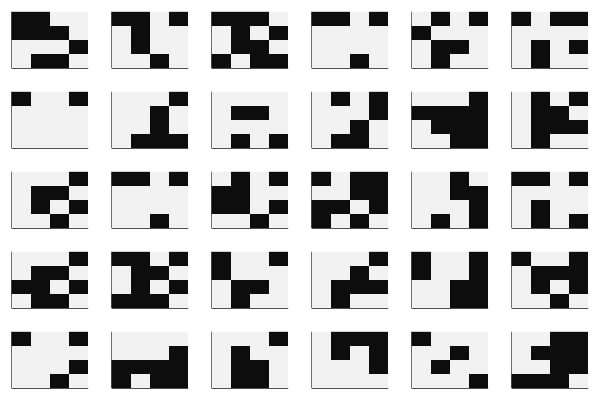

In [8]:
real = []
fake = []

for m in 1:batch
    x = data_train[m] |> vec 
    push!(real, Int.(x))
    push!(fake, run_g(nbatch = 1)) #Find a better way to preprocess real and fake data...
end
data = collect(zip(real, fake)) 
println(real[1])
plot([heatmap(reshape(d, n, n), color=:grays, colorbar = false, ticks = false) for d in fake]...)

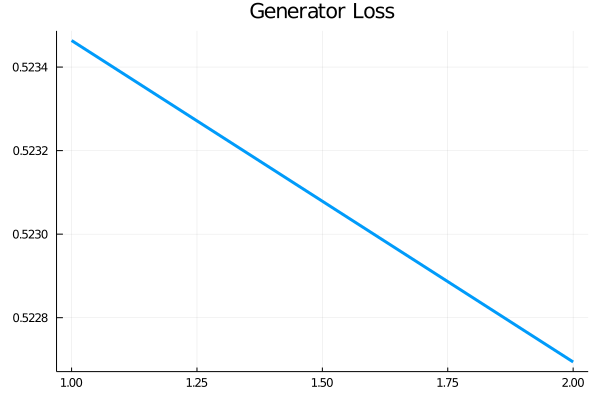

In [9]:
plot(gLoss_vals, title = "Generator Loss", linewidth=3, legend = false)

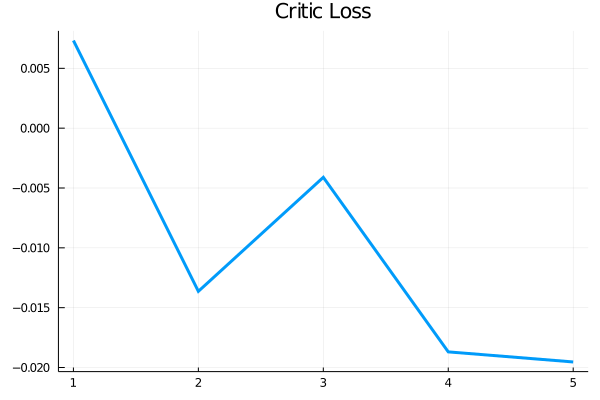

In [10]:
plot(criticLoss_vals, title = "Critic Loss", linewidth=3, legend = false)

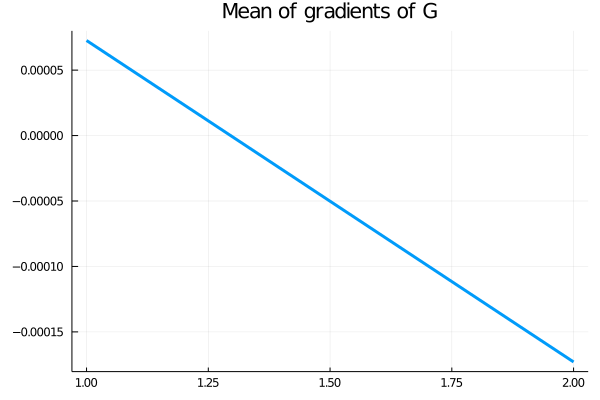

In [11]:
plot(mean_grads, title = "Mean of gradients of G", linewidth=3, legend = false)

In [12]:
#Testing the Critic
m = rand(1:train)
x = data_train[m] |> vec 
real = Int.(x)
fake = run_g(nbatch = 1)
println("Predicted distance between fake and real data: ", pred_WassersteinDist(f, real, fake)) #Should print a number close to 0

Predicted distance between fake and real data: 0.07916704


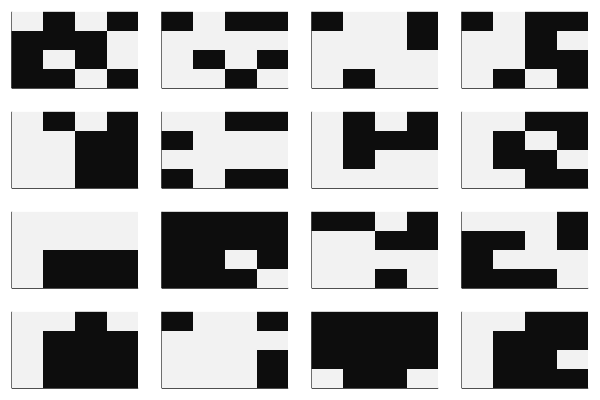

In [13]:
#Testing the Generator

nsamples = 16
samples = run_g(nbatch = nsamples)
plot([heatmap(reshape(samples[:, i], n, n), color=:grays, colorbar = false, ticks = false) for i in 1:nsamples]...)

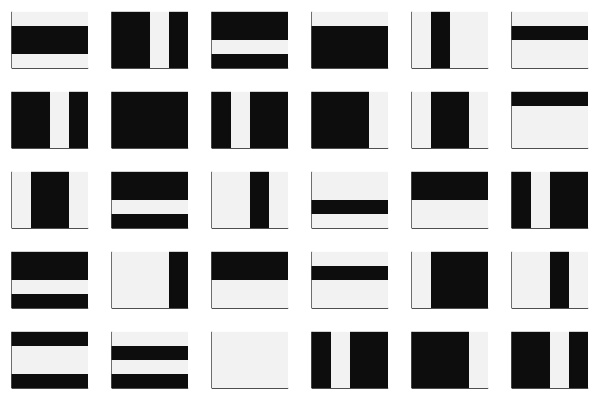

In [14]:
plot([heatmap(x, color=:grays, colorbar = false, ticks = false) for x in data_train]...)